In [15]:
from pathlib import Path
import nibabel as nib
from cogpred.utils.configuration import get_config
import numpy as np
from sklearn.utils import Bunch
config = get_config()


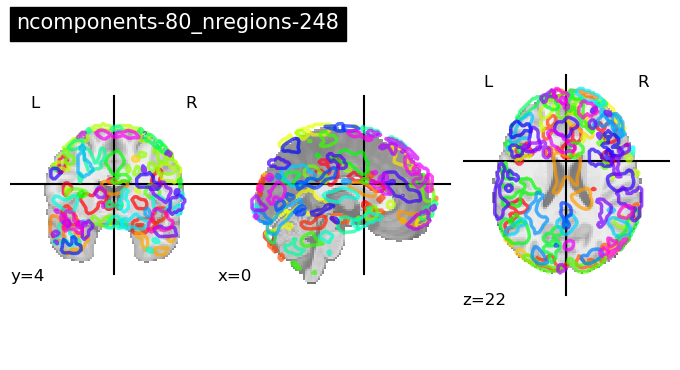

In [17]:
from neuroginius.atlas import Atlas, atlas_mapping

i_path = Path(config["parcellations"]) / "ncomponents-80_nregions-248"
atlas = Atlas.from_path(i_path)
atlas.plot()

In [8]:
import joblib

ri = joblib.load("regions_index.joblib")

In [12]:
import numpy as np
np.unique(ri)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])